In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv("../data/classification/count_dataset_for_multilabel.csv")
df.head()

,project_name,package#A,package#ACGAN,package#APDrawing,package#APDrawingGAN,package#APDrawingGAN.data,package#APDrawingGAN.data.base_data_loader,package#APDrawingGAN.data.base_dataset,package#APDrawingGAN.data.face_landmark,package#APDrawingGAN.data.image_folder,...,topic#vim,topic#virtual-reality,topic#vue,topic#wagtail,topic#web-components,topic#webapp,topic#webpack,topic#windows,topic#wordpress,topic#xml
0,01joy#news-search-engine,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,05bit#peewee-async,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0k#shyaml,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0x00-0x00#ShellPop,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0xAX#linux-insides,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

def get_forest_clf(X_train, y_train):
    clf = RandomForestClassifier(criterion='gini', min_samples_leaf=5, max_depth=10, n_estimators=10, random_state=42)
    clf_model = OneVsRestClassifier(clf)
    clf_model.fit(X_train, y_train)
    return clf_model

def get_xgboost_clf(X_train, y_train, X_test, y_test):
    clf = XGBClassifier(learning_rate=0.05,
                        n_estimators=100,
                        max_depth=5,
                        min_child_weight=5.0,
                        gamma=1,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        objective="binary:logistic",
                        random_state=42)
    
    clf.fit(X_train, y_train, verbose=False, eval_set=[(X_test, y_test)])

    return clf

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve


def get_youden_threshold(model, X, y_true):
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba, pos_label=1)
    auc = roc_auc_score(y_true, y_predict_proba)
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color="red", label=f"ROC curve")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker="o", color="navy", ms=10, 
             label=f"Youden Threshold={youden_threshold:.2f}\nAUC={auc:.3f})")
    plt.plot([0,1], [0,1] , color="black", ls="--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('FPR', fontsize=12)
    plt.ylabel('TPR', fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend(prop={'size':12} , loc=4)
    plt.show()
    
    return youden_threshold


def get_threshold(model, X, y_true):
    y_predict_proba = model.predict_proba(X)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    idx = np.argmin(np.abs(precision - recall))
    threshold = thresholds[idx]
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds:
        queue_rate.append((y_predict_proba >= thr).mean())
        
    plt.figure(figsize=(5, 5))
    plt.plot(thresholds, precision[1:], label="Precision")
    plt.plot(thresholds, recall[1:], label="Recall")
    plt.plot(thresholds, f1[1:], label="F1-Score")
    plt.plot(thresholds, queue_rate, label="Queue Rate")
    plt.legend(loc=0)
    plt.xlim([0.025, threshold + 0.2])
    plt.xlabel("Threshold", fontsize=12)
    plt.ylabel("Score", fontsize=12)
    plt.axvline(threshold, color="k", ls="--")
    plt.title(label = F"Threshold={threshold:.3f}", fontsize=12)
    plt.show()
    
    return threshold

In [32]:
def evaluate(X_train, X_test, y_train, y_test, features):
    for f in features: 
        y_train_unit, y_test_unit = y_train[f].values, y_test[f].values
        clf = get_xgboost_clf(X_train, y_train_unit, X_test, y_test_unit)
        
        threshhold = get_youden_threshold(clf, X_test, y_test_unit)
        
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = [1 if p[1] > threshhold else 0 for p in y_pred_proba]
        print('================', f, '================')
        print(classification_report(y_test_unit, y_pred, labels=[0, 1]))
        
        threshhold = get_threshold(clf, X_test, y_test_unit)
        
        y_pred_proba = clf.predict_proba(X_test)
        y_pred = [1 if p[1] > threshhold else 0 for p in y_pred_proba]
        print('================', f, '================')
        print(classification_report(y_test_unit, y_pred, labels=[0, 1]))

In [11]:
X_columns = [c for c in df.columns if c.startswith('ext') or c.startswith('package')]
# X_columns

In [12]:
y_columns = [c for c in df.columns if c.startswith('tag') or c.startswith('topic')]
# y_columns

In [13]:
X = df[X_columns].to_numpy()
X.shape

(2853, 19235)

In [14]:
y = df[y_columns]
y.shape

(2853, 9309)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, train_size=0.7)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1997, 19235), (856, 19235), (1997, 9309), (856, 9309))

## Tags prediction

In [17]:
tags = [c for c in y.columns if c.startswith('tag') and y[c].sum() > 50]
print(len(tags))
# tags

30


/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


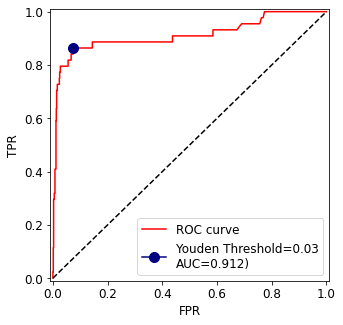

================ tag#android ================
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       812
           1       0.38      0.84      0.52        44

    accuracy                           0.92       856
   macro avg       0.69      0.88      0.74       856
weighted avg       0.96      0.92      0.94       856



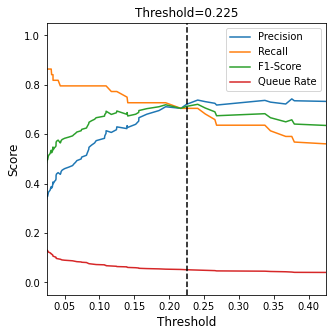

================ tag#android ================
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       812
           1       0.72      0.70      0.71        44

    accuracy                           0.97       856
   macro avg       0.85      0.84      0.85       856
weighted avg       0.97      0.97      0.97       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


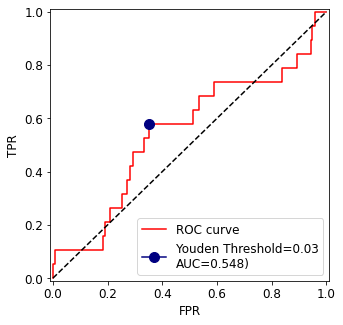

================ tag#api ================
              precision    recall  f1-score   support

           0       0.98      0.65      0.78       837
           1       0.03      0.53      0.06        19

    accuracy                           0.65       856
   macro avg       0.51      0.59      0.42       856
weighted avg       0.96      0.65      0.77       856



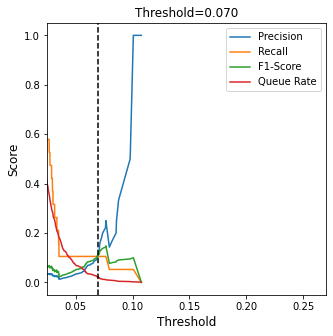

================ tag#api ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       837
           1       0.11      0.11      0.11        19

    accuracy                           0.96       856
   macro avg       0.55      0.54      0.54       856
weighted avg       0.96      0.96      0.96       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


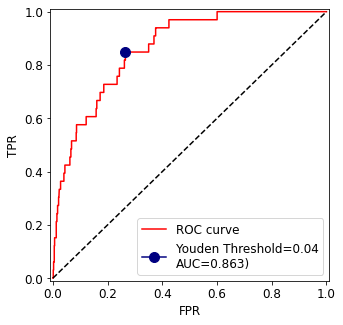

================ tag#bot ================
              precision    recall  f1-score   support

           0       0.99      0.74      0.84       823
           1       0.11      0.82      0.19        33

    accuracy                           0.74       856
   macro avg       0.55      0.78      0.52       856
weighted avg       0.96      0.74      0.82       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


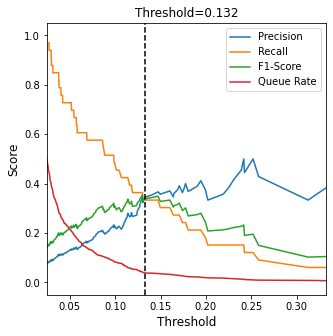

================ tag#bot ================
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       823
           1       0.34      0.33      0.34        33

    accuracy                           0.95       856
   macro avg       0.66      0.65      0.66       856
weighted avg       0.95      0.95      0.95       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


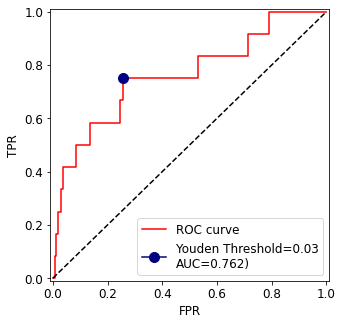

================ tag#cli ================
              precision    recall  f1-score   support

           0       0.99      0.75      0.85       844
           1       0.04      0.67      0.07        12

    accuracy                           0.74       856
   macro avg       0.51      0.71      0.46       856
weighted avg       0.98      0.74      0.84       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


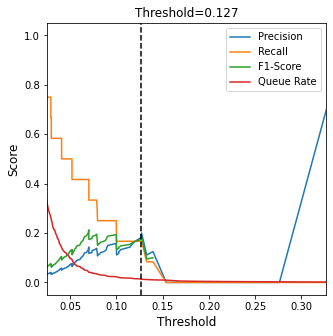

================ tag#cli ================
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       844
           1       0.18      0.17      0.17        12

    accuracy                           0.98       856
   macro avg       0.58      0.58      0.58       856
weighted avg       0.98      0.98      0.98       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


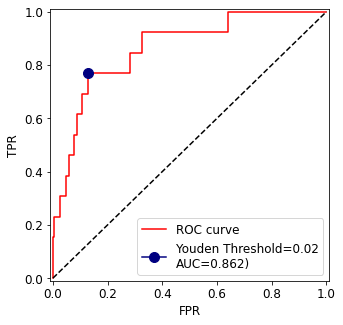

================ tag#computer-vision ================
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       843
           1       0.08      0.69      0.14        13

    accuracy                           0.87       856
   macro avg       0.54      0.78      0.53       856
weighted avg       0.98      0.87      0.92       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


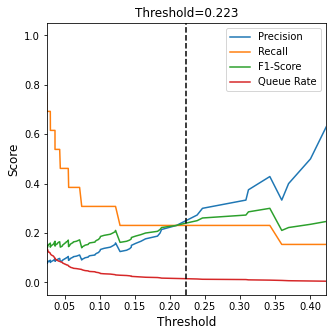

================ tag#computer-vision ================
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       843
           1       0.25      0.23      0.24        13

    accuracy                           0.98       856
   macro avg       0.62      0.61      0.61       856
weighted avg       0.98      0.98      0.98       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


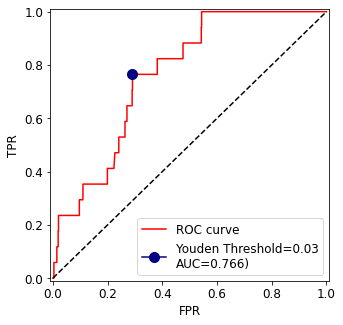

================ tag#cryptocurrency ================
              precision    recall  f1-score   support

           0       0.99      0.71      0.83       839
           1       0.05      0.71      0.09        17

    accuracy                           0.71       856
   macro avg       0.52      0.71      0.46       856
weighted avg       0.97      0.71      0.81       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


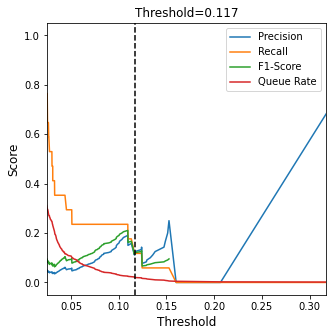

================ tag#cryptocurrency ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       839
           1       0.12      0.12      0.12        17

    accuracy                           0.97       856
   macro avg       0.55      0.55      0.55       856
weighted avg       0.97      0.97      0.97       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


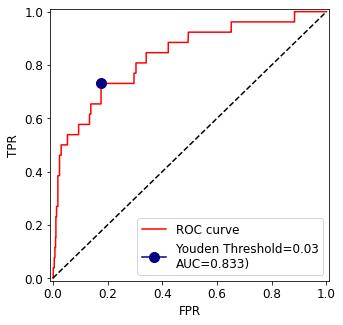

================ tag#data-science ================
              precision    recall  f1-score   support

           0       0.99      0.82      0.90       830
           1       0.11      0.69      0.19        26

    accuracy                           0.82       856
   macro avg       0.55      0.76      0.54       856
weighted avg       0.96      0.82      0.88       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


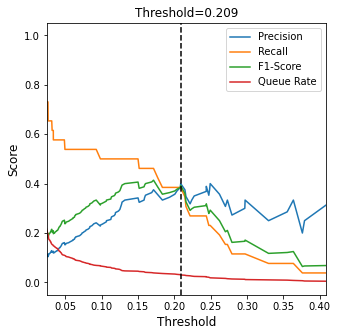

================ tag#data-science ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       830
           1       0.40      0.38      0.39        26

    accuracy                           0.96       856
   macro avg       0.69      0.68      0.69       856
weighted avg       0.96      0.96      0.96       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


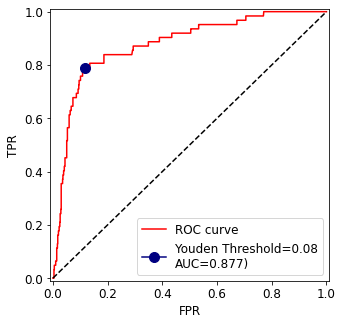

================ tag#deep-learning ================
              precision    recall  f1-score   support

           0       0.98      0.88      0.93       794
           1       0.34      0.77      0.48        62

    accuracy                           0.88       856
   macro avg       0.66      0.83      0.70       856
weighted avg       0.93      0.88      0.90       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


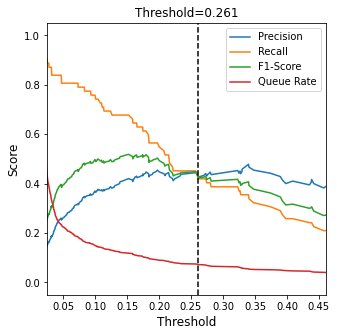

================ tag#deep-learning ================
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       794
           1       0.43      0.42      0.42        62

    accuracy                           0.92       856
   macro avg       0.69      0.69      0.69       856
weighted avg       0.92      0.92      0.92       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


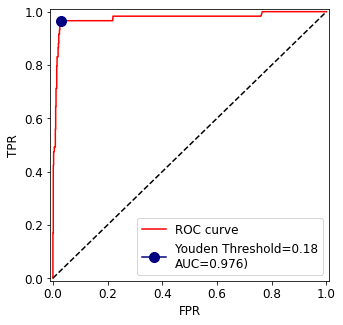

================ tag#django ================
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       797
           1       0.71      0.95      0.81        59

    accuracy                           0.97       856
   macro avg       0.85      0.96      0.90       856
weighted avg       0.98      0.97      0.97       856



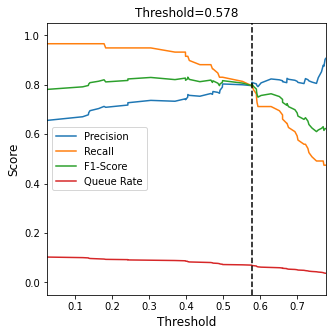

================ tag#django ================
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       797
           1       0.81      0.80      0.80        59

    accuracy                           0.97       856
   macro avg       0.90      0.89      0.89       856
weighted avg       0.97      0.97      0.97       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


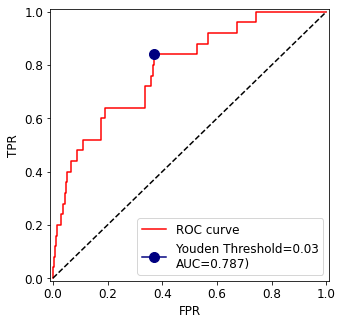

================ tag#docker ================
              precision    recall  f1-score   support

           0       0.99      0.63      0.77       831
           1       0.06      0.80      0.11        25

    accuracy                           0.64       856
   macro avg       0.53      0.72      0.44       856
weighted avg       0.96      0.64      0.75       856



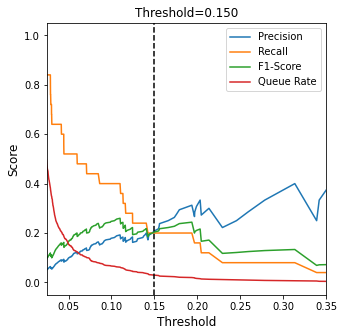

================ tag#docker ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       831
           1       0.21      0.20      0.20        25

    accuracy                           0.95       856
   macro avg       0.59      0.59      0.59       856
weighted avg       0.95      0.95      0.95       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


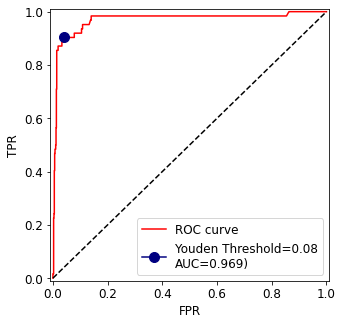

================ tag#flask ================
              precision    recall  f1-score   support

           0       0.99      0.96      0.98       794
           1       0.63      0.89      0.74        62

    accuracy                           0.95       856
   macro avg       0.81      0.92      0.86       856
weighted avg       0.96      0.95      0.96       856



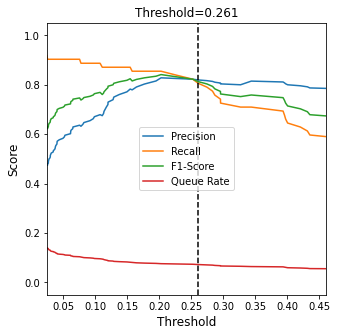

================ tag#flask ================
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       794
           1       0.82      0.81      0.81        62

    accuracy                           0.97       856
   macro avg       0.90      0.90      0.90       856
weighted avg       0.97      0.97      0.97       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


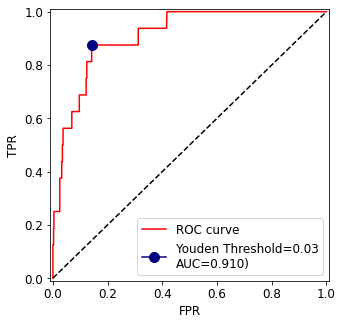

================ tag#google ================
              precision    recall  f1-score   support

           0       1.00      0.86      0.92       840
           1       0.10      0.81      0.18        16

    accuracy                           0.86       856
   macro avg       0.55      0.84      0.55       856
weighted avg       0.98      0.86      0.91       856



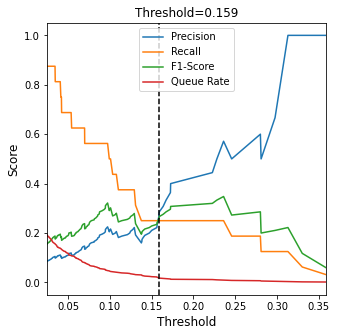

================ tag#google ================
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       840
           1       0.27      0.25      0.26        16

    accuracy                           0.97       856
   macro avg       0.63      0.62      0.62       856
weighted avg       0.97      0.97      0.97       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


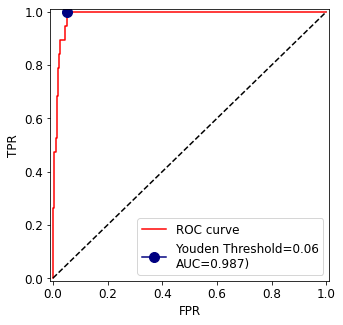

================ tag#gradle ================
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       837
           1       0.30      0.95      0.46        19

    accuracy                           0.95       856
   macro avg       0.65      0.95      0.71       856
weighted avg       0.98      0.95      0.96       856



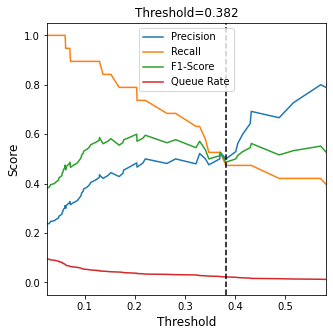

================ tag#gradle ================
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       837
           1       0.50      0.47      0.49        19

    accuracy                           0.98       856
   macro avg       0.74      0.73      0.74       856
weighted avg       0.98      0.98      0.98       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


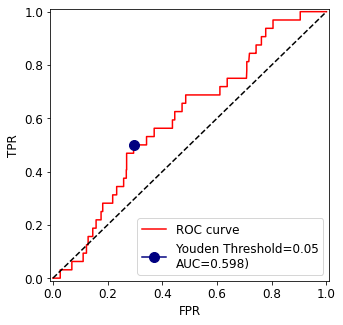

================ tag#hacktoberfest ================
              precision    recall  f1-score   support

           0       0.97      0.71      0.82       824
           1       0.06      0.47      0.10        32

    accuracy                           0.70       856
   macro avg       0.51      0.59      0.46       856
weighted avg       0.94      0.70      0.79       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


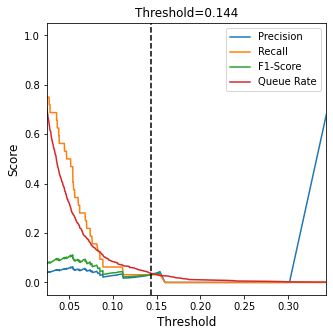

================ tag#hacktoberfest ================
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       824
           1       0.03      0.03      0.03        32

    accuracy                           0.93       856
   macro avg       0.50      0.50      0.50       856
weighted avg       0.93      0.93      0.93       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


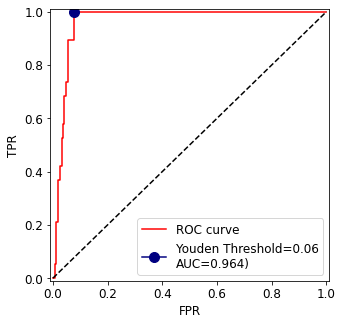

================ tag#java ================
              precision    recall  f1-score   support

           0       1.00      0.92      0.96       837
           1       0.22      0.95      0.36        19

    accuracy                           0.92       856
   macro avg       0.61      0.94      0.66       856
weighted avg       0.98      0.92      0.95       856



/var/folders/4s/hl9y6lqs3h1c9qxxnbjmtvsr0000gn/T/ipykernel_27112/303569057.py:37: RuntimeWarning: invalid value encountered in double_scalars
  f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))


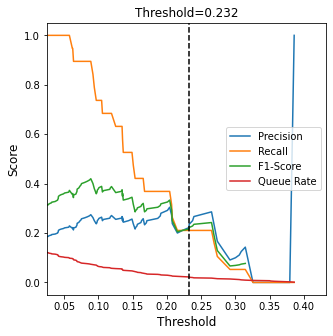

================ tag#java ================
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       837
           1       0.22      0.21      0.22        19

    accuracy                           0.97       856
   macro avg       0.60      0.60      0.60       856
weighted avg       0.97      0.97      0.97       856



/usr/local/lib/python3.9/site-packages/xgboost/sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


KeyboardInterrupt: 

In [33]:
evaluate(X_train, X_test, y_train, y_test, tags)